UNICEF Arm 2030 Vision #1: Flood Prediction in Malawi
=============================================
Edimer David Jaramillo   
Abril de 2020

## Instalando y cargando bibliotecas

In [0]:
install.packages("h2o", dependencies = TRUE)
library(tidyverse)
library(h2o)

## Importando datos

In [0]:
load("/content/dataTrain.Rdata")
load("/content/dataTest.Rdata")

## Modelo XGBoost

In [112]:
# Iniciando h2o
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# Train y Test h2o
df_train <- dataTrain %>%
   select(-Square_ID)

# Datos h2o
datos_h2o <- as.h2o(x = df_train, destination_frame = "datos_h2o")

particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.8, 0.10),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_h2o")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_h2o")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_h2o")

# Se define la variable respuesta y los predictores.
var_respuesta <- "target_2015"

# Para este modelo se emplean todos los predictores disponibles.
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)

# Modelo XGB h2o
xgb <- h2o.xgboost(x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,model_id = "xgb_s7"
                  ,stopping_rounds = 50
                  ,stopping_metric = "RMSE"
                  ,distribution = "poisson"
                  ,score_tree_interval = 5
                  ,learn_rate=0.01
                  ,ntrees=7500
                  ,subsample = 1
                  ,col_sample_rate = 1
                  ,colsample_bytree = 1
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = 5
                  ,max_runtime_secs = 3600
                  ,nfolds = 10
                  ,seed = 123
                  ,max_depth = 30
                  ,min_rows = 10)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         30 seconds 48 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    18 days  
    H2O cluster name:           H2O_started_from_R_root_bbd426 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   10.00 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 

  |======================================================================| 100%
  |=================================================================

In [113]:
xgb

Model Details:

H2ORegressionModel: xgboost
Model ID:  xgb_s7 
Model Summary: 
  number_of_trees
1             964


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  0.00924477
RMSE:  0.09614973
MAE:  0.04147074
RMSLE:  0.07001786
Mean Residual Deviance :  0.2808119


H2ORegressionMetrics: xgboost
** Reported on validation data. **

MSE:  0.009196499
RMSE:  0.09589838
MAE:  0.0407681
RMSLE:  0.06823105
Mean Residual Deviance :  0.2682568


H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.01163812
RMSE:  0.1078801
MAE:  0.04597991
RMSLE:  0.07815672
Mean Residual Deviance :  0.2922582


Cross-Validation Metrics Summary: 
                              mean           sd  cv_1_valid  cv_2_valid
mae                    0.045955464 0.0025274274 0.047034174  0.04170367
mean_residual_deviance  0.29211816   0.01877056  0.30037773  0.26780495
mse 

## Predicciones

In [114]:
# ============================= Predicciones ====================================== #

# Train
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Train)
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Submission)
predichos_subm <- h2o.predict(xgb, as.h2o(dataTest)) %>%
  as.data.frame() %>% pull(predict)
predichos_subm[predichos_subm > 1] <- 1 
dataTest %>% 
  select(Square_ID) %>% 
  mutate(target = predichos_subm) ->
  subm7


# Exportando predicciones
write.csv(subm7, file = "subm7.csv", row.names = FALSE)

RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target)))
)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


data,RMSE
<fct>,<dbl>
Train,0.09614973
Test,0.10160960


## Importancia de variables

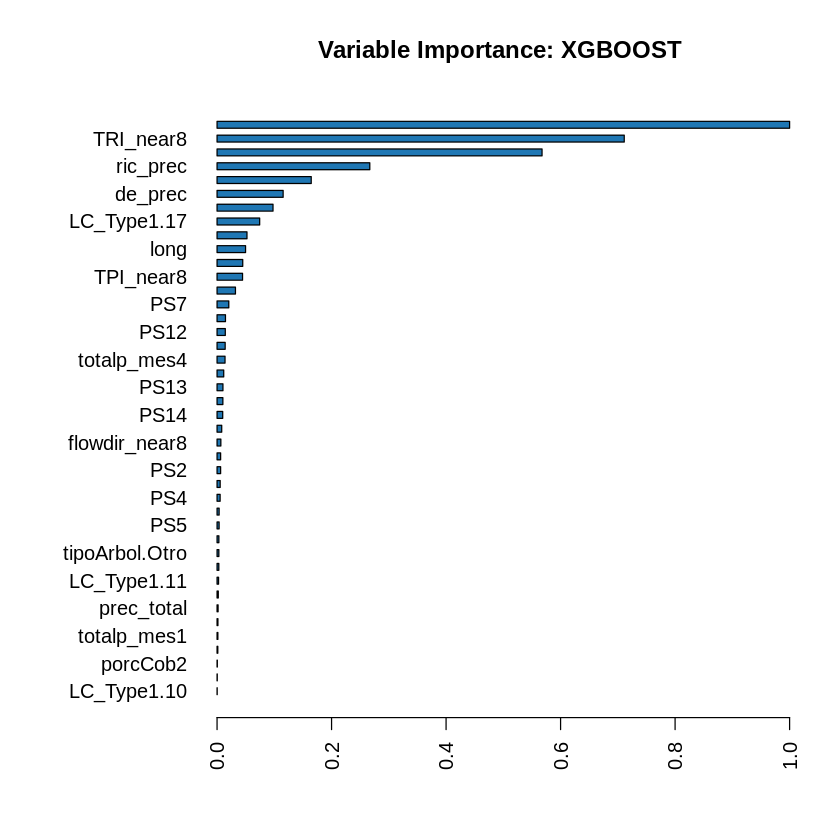

In [115]:
h2o.varimp_plot(xgb, num_of_features = ncol(dataTrain))

## Guardar modelo

In [116]:
h2o.saveModel(xgb, path = "XGB_Subm7", force = TRUE)

[1] "/content/XGB_Subm7/xgb_s7"

## Gráficos

  |======================================================================| 100%


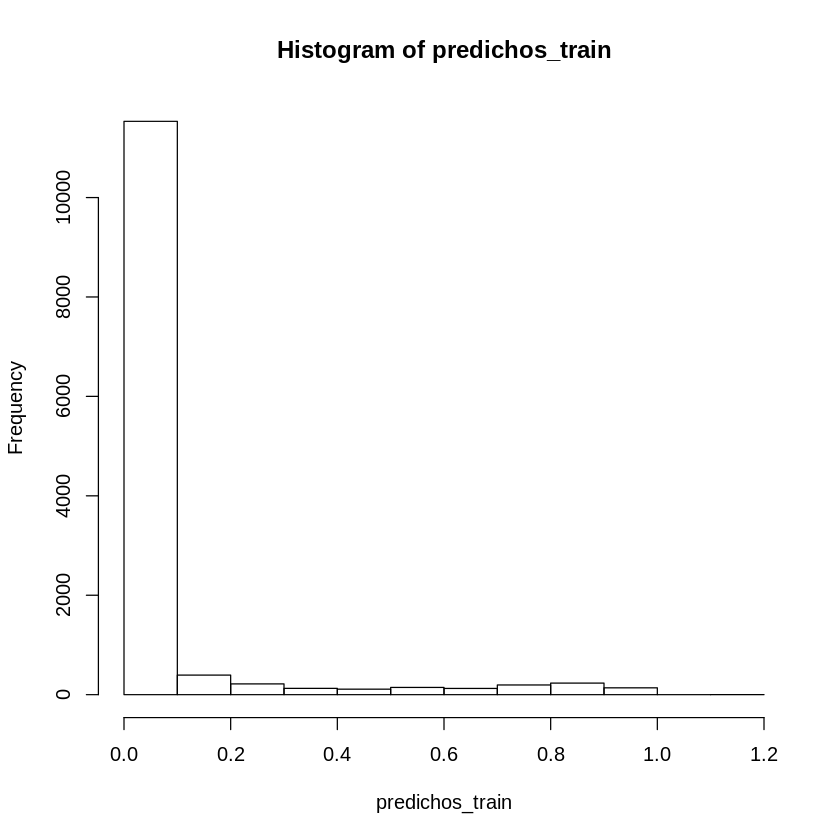

In [117]:
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)
hist(predichos_train)

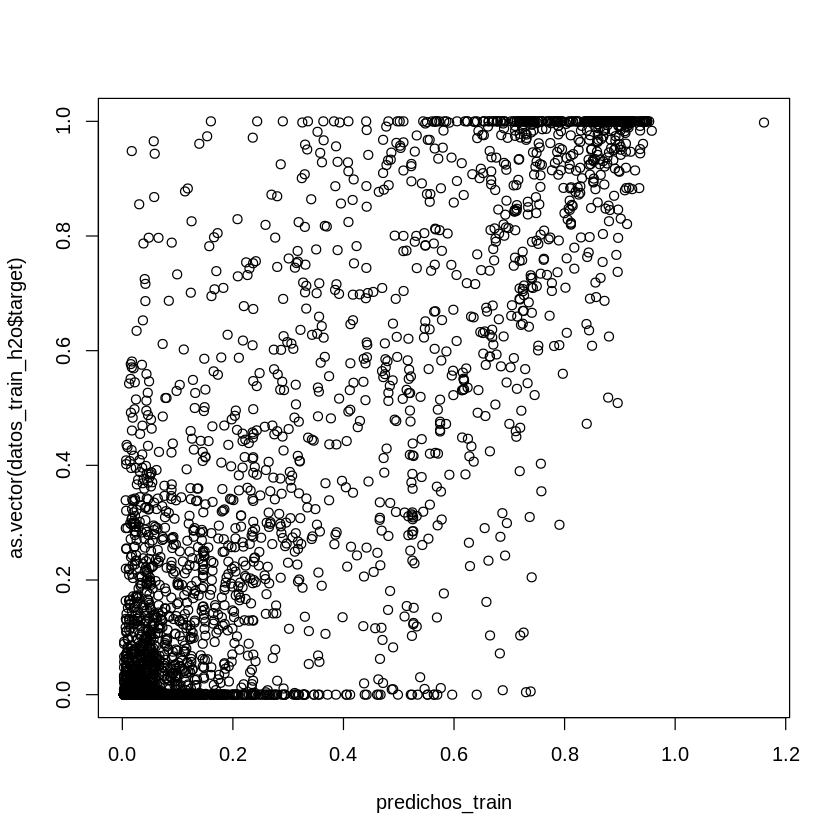

In [118]:
plot(predichos_train, as.vector(datos_train_h2o$target))

  |======================================================================| 100%


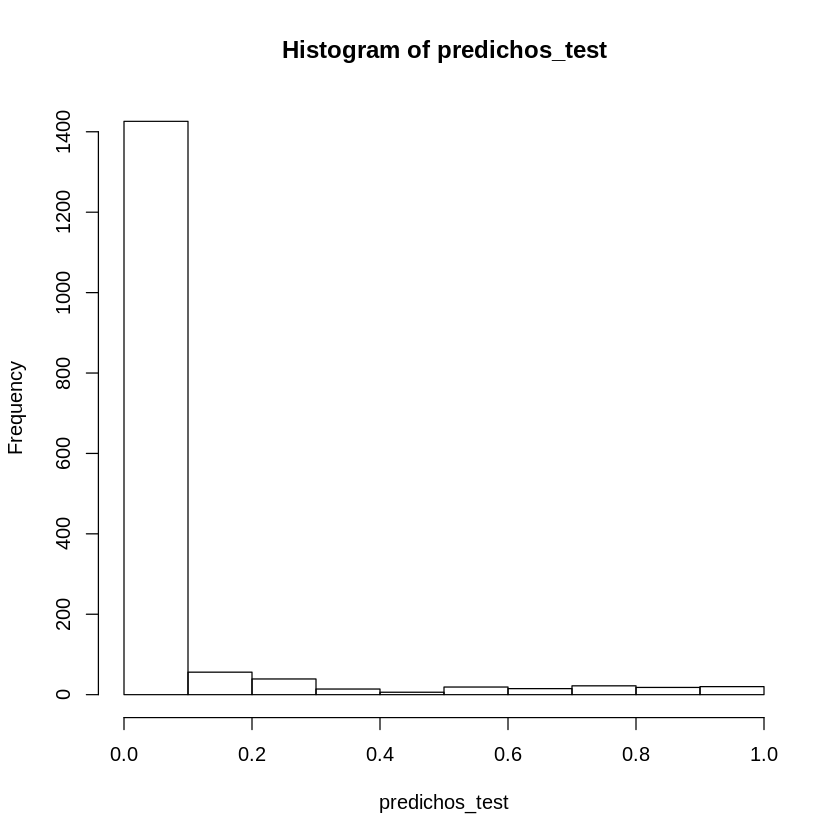

In [119]:
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict) 
hist(predichos_test)

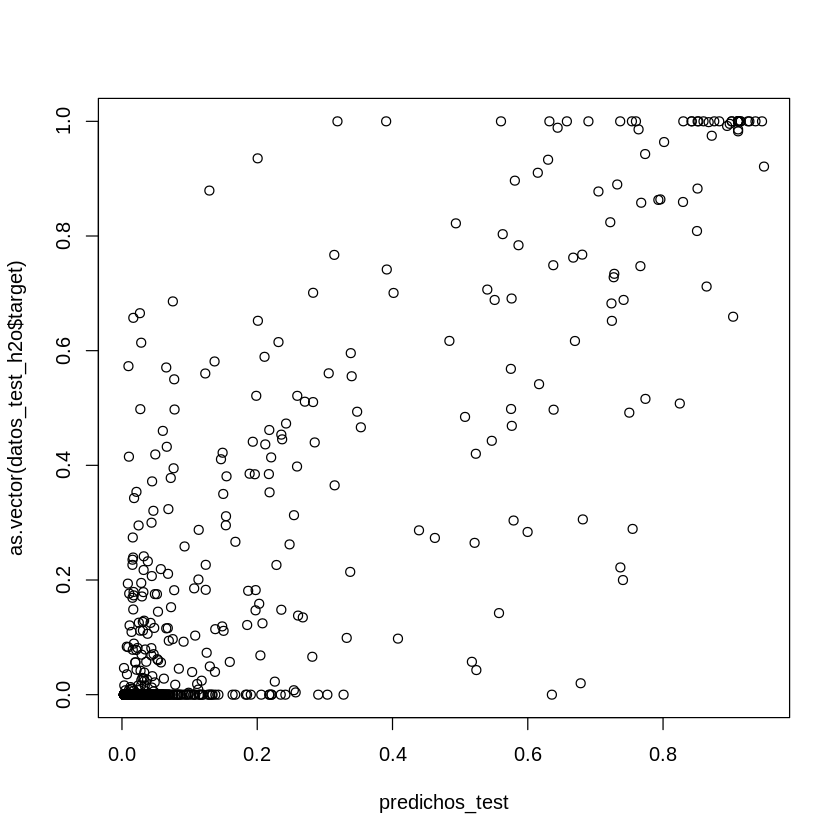

In [120]:
plot(predichos_test, as.vector(datos_test_h2o$target))

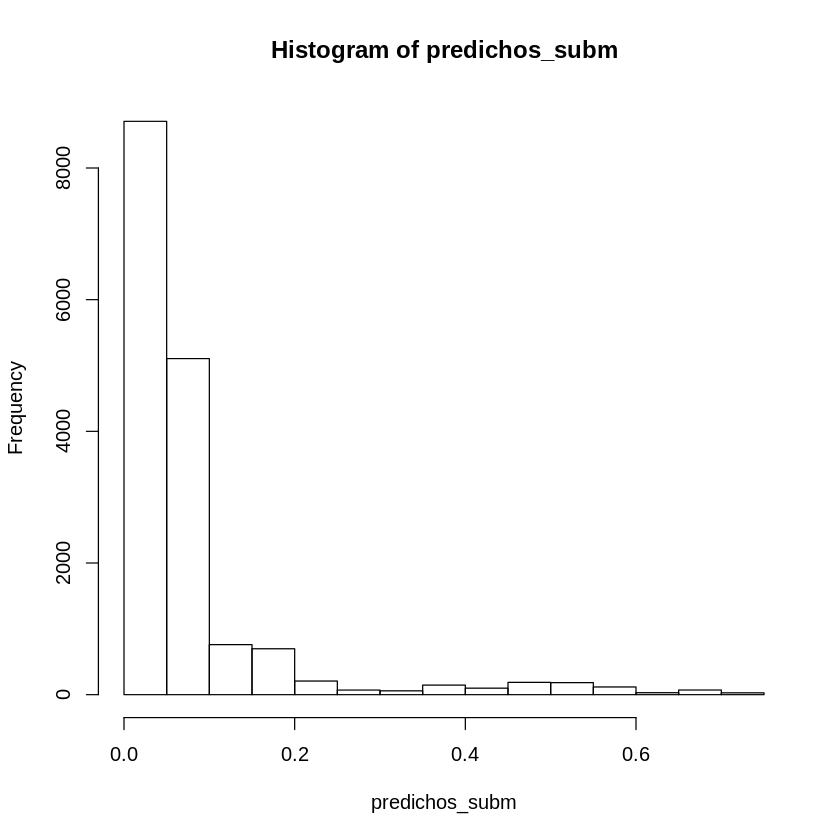

In [121]:
hist(predichos_subm)